In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib import cm
from matplotlib.tri import Triangulation

import ast

In [2]:
def parse_results(file_name):
    grid_search_results = []
    with open(file_name, 'r') as file:
        for line in file.readlines():
            if line[0:4] == '----':
                grid_search_results.append([])
                continue

            if line[0] == '(':
                fixed_line = '[' + line.strip().replace(') (', '), (') + ']'
                params = ast.literal_eval(fixed_line)
                nested = [list(zip(key.split(','), np.array(val).flatten())) for (key, val) in params]
                unnested = [item for sublist in nested for item in sublist]
                grid_search_results[-1].append({key: val for (key, val) in unnested})
                grid_search_results[-1].append([])
                continue

            result = line

            if result[0] == '[':
                grid_search_results[-1][-1].append(ast.literal_eval(result))
                continue

    grid_search_results = [(params, np.array(values)) for params, values in grid_search_results]
    return grid_search_results

In [69]:
# hyp_res = parse_results('grid_search_results/hyp_broad_search_50_cutoff.txt')
# euc_res = parse_results('grid_search_results/tom_euc_overall-liking_400.txt')
both_res = parse_results('grid_search_results/both_initial_10.txt')
hyp_res = both_res[:len(both_res)//2]
euc_res = both_res[len(both_res)//2:]

In [70]:
hyp_params = np.array([p for p, _ in hyp_res])
hyp_values = np.array([v for _, v in hyp_res])

euc_params = np.array([p for p, _ in euc_res])
euc_values = np.array([v for _, v in euc_res])

hyp_values.shape, euc_values.shape

((45, 5, 10), (45, 5, 10))

In [84]:
euc_values

0.6723571240310905

In [71]:
param_grid = {
    'model_type': ['hyp', 'euc'],
    'num_hidden_layers': [0,1,2,4,8],
    'layer_size': [64,128,256],
    'lr': [0.001,0.003,0.01],
    'weight_decay': [0.001],
    'batch_size': [1024],
    'epochs': [10],
    'curvature': [-1]
}

In [72]:
num_hidden_layers = np.array(param_grid['num_hidden_layers']).repeat(len(param_grid['layer_size']))
layer_size = np.tile(param_grid['layer_size'], len(param_grid['num_hidden_layers']))

0.3055081457783558 -4.7007646832466494e-05
0.35329822712420894 0.8838914463086255


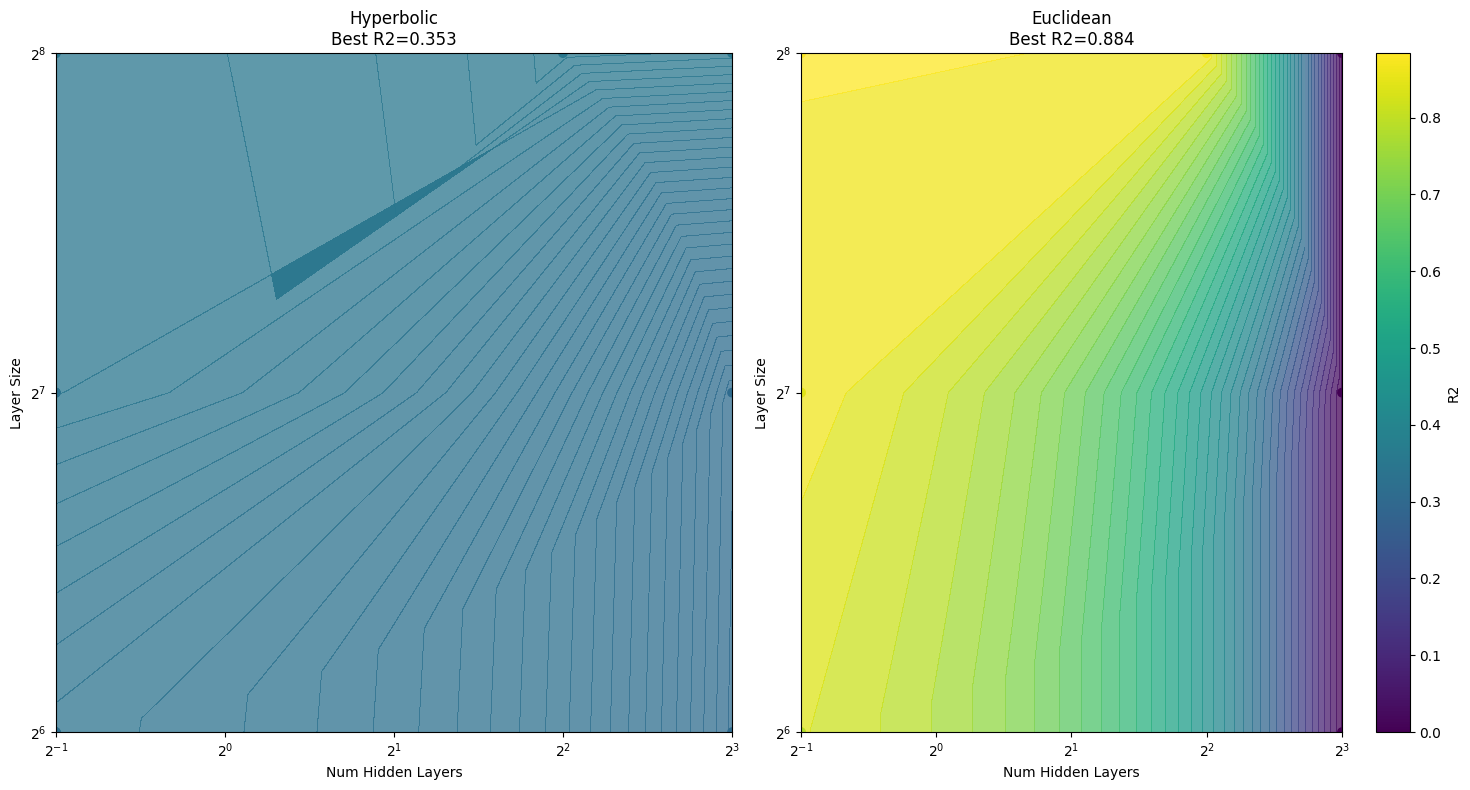

0.3324157993728367 -8.24192521991427e-05
0.3685533452104578 0.8842876708441734


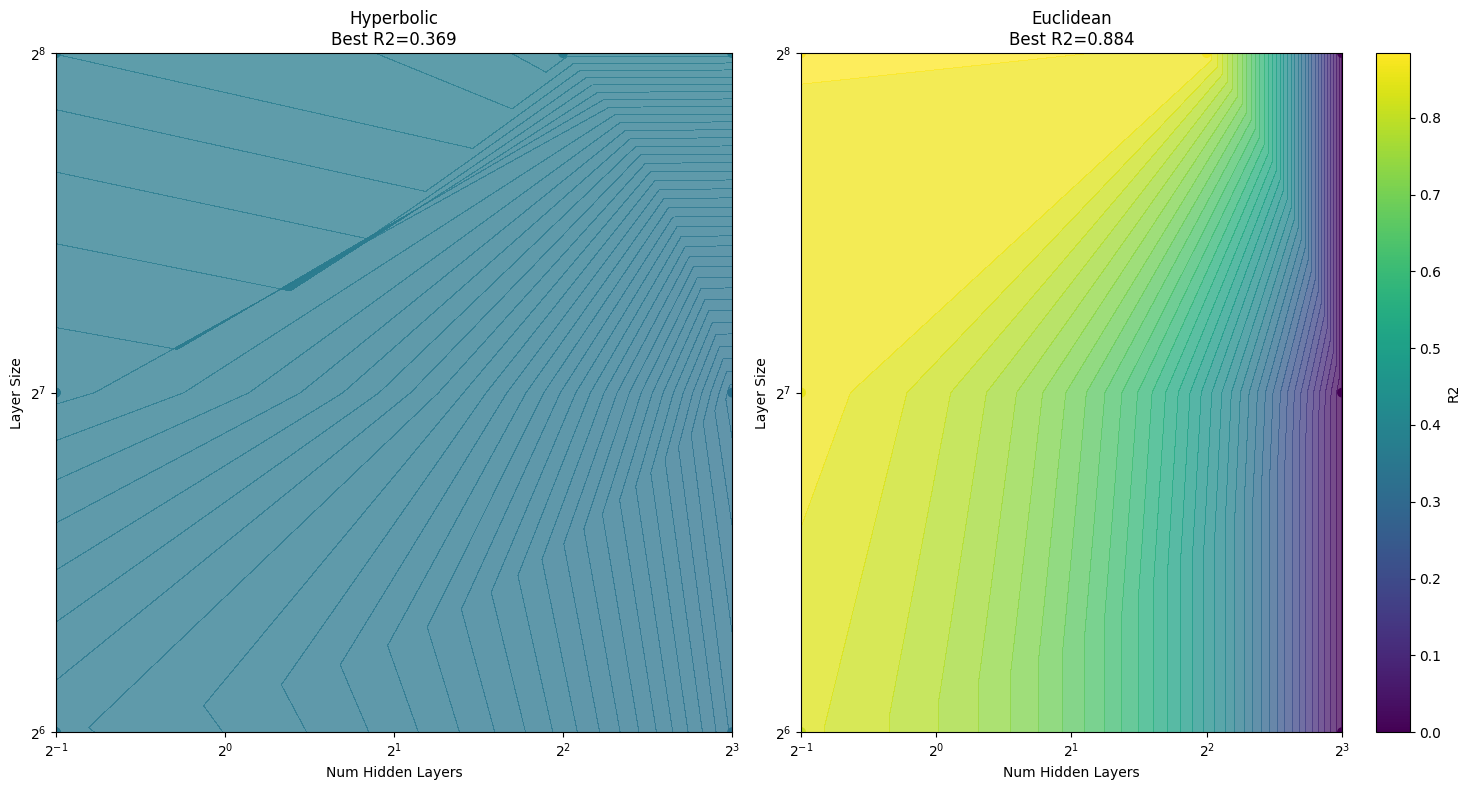

0.3436023388520043 -0.00020382505530700093
0.37257594468126093 0.8796591642986608


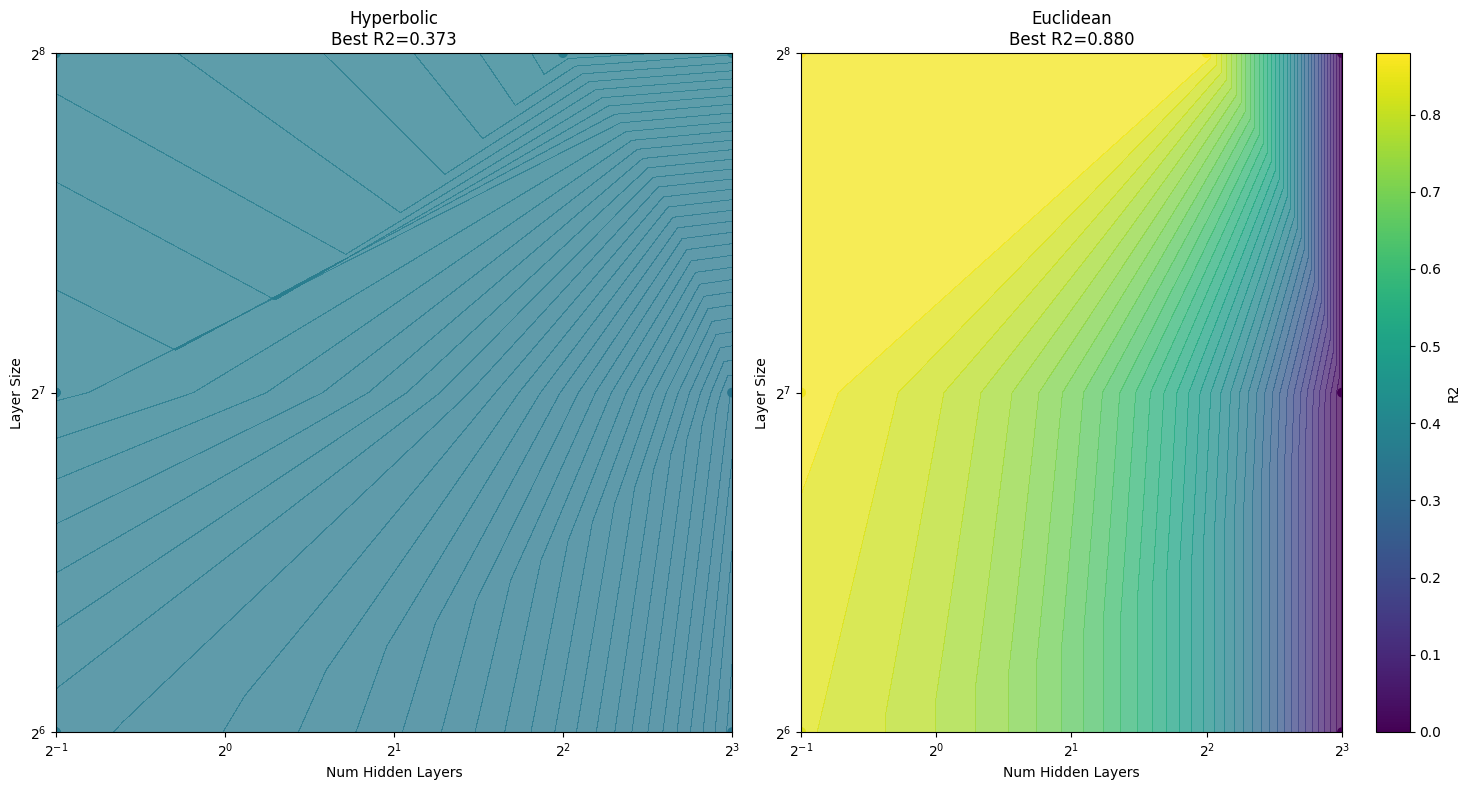

In [94]:
for i, lr in enumerate(param_grid['lr']):
    hyp_data = hyp_values.mean(axis=1)[:,-1].reshape(-1,len(param_grid['lr']))[:,i]
    euc_data = euc_values.mean(axis=1)[:,-1].reshape(-1,len(param_grid['lr']))[:,i]

    min_val = min(np.min(hyp_data), np.min(euc_data))
    max_val = max(np.max(hyp_data), np.max(euc_data))

    print(np.min(hyp_data), np.min(euc_data))
    print(np.max(hyp_data), np.max(euc_data))

    cmap = plt.cm.viridis
    norm = Normalize(vmin=min_val, vmax=max_val)

    num_hidden_layers_adjust = np.append(np.zeros(11)+0.5, num_hidden_layers[11:])

    mesh = Triangulation(num_hidden_layers_adjust, layer_size)  #create tri mesh


    plt.figure(figsize=(15,8))
    # plt.suptitle(f'Hyperbolic     |     Euclidean', fontsize=16, y=1)

    plt.subplot(121)
    plt.tricontourf(mesh, hyp_data, levels=40, cmap=cmap, norm=norm, alpha=0.75)
    plt.scatter(num_hidden_layers_adjust, layer_size, c=hyp_data, cmap=cmap, norm=norm)

    plt.title(f'Hyperbolic\nBest R2={np.max(hyp_data):.3f}')
    plt.xlabel('Num Hidden Layers')
    plt.ylabel('Layer Size')

    plt.xscale('log', base=2)
    plt.yscale('log', base=2)


    plt.subplot(122)
    euc_contourf = plt.tricontourf(mesh, euc_data, levels=40, cmap=cmap, norm=norm, alpha=0.75)
    euc_scatter = plt.scatter(num_hidden_layers_adjust, layer_size, c=euc_data, cmap=cmap, norm=norm)
    plt.colorbar(euc_scatter, label='R2')


    plt.title(f'Euclidean\nBest R2={np.max(euc_data):.3f}')
    plt.xlabel('Num Hidden Layers')
    plt.ylabel('Layer Size')

    plt.xscale('log', base=2)
    plt.yscale('log', base=2)

    plt.tight_layout()
    plt.show()